In [27]:
# Load the schema for the wikipedia edit files
from pyspark.sql.types import StructType
import json
with open('wikipedia_edits_schema.json', 'r') as json_schema_file:
    schema = StructType.fromJson(json.load(json_schema_file))

In [28]:
# Load all of the edit history
edits = sqlCtx.read.json(
    'enwiki-latest-pages-meta-history*.json.gz',
    schema = schema
)

In [29]:
# Filter out uninteresting articles and users
filtered = edits.rdd.filter(
    lambda row: 
    row.user_id is not None  # Keep only logged in users
    and row.redirect_target is None  # Save only edits that are not redirects
    and row.article_namespace == 0  # Save only edits on articles, not talk pages
)
filtered = filtered.toDF(schema=schema)
filtered.registerTempTable('filtered_edits')

## Summary Statistics

In [30]:
import pandas as pd
import numpy as np

In [31]:
# User count
user_count = sqlCtx.sql('select distinct user_id from filtered_edits').count()
print user_count

5583723


In [32]:
# Article count
article_count = sqlCtx.sql('select distinct(article_id) from filtered_edits').count()
print article_count

4936765


### Edits per User

In [33]:
edits_per_user = sqlCtx.sql('select user_id,count(user_id) as number_of_edits from filtered_edits group by user_id').collect()

In [34]:
edits_per_user_df = pd.DataFrame(
    edits_per_user, 
    columns = ('user_id', 'edits')
)
edits_per_user_df = edits_per_user_df.set_index('user_id')

In [35]:
np.percentile(edits_per_user_df['edits'], 75)

6.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c942dc610>]], dtype=object)

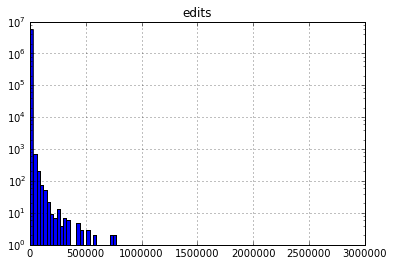

In [36]:
%matplotlib inline
edits_per_user_df.hist(log=True, bins=100)

### Articles per User

In [37]:
articles_per_user = sqlCtx.sql('select user_id,count(distinct(article_id)) as number_of_articles from filtered_edits group by user_id').collect()

In [38]:
articles_per_user_df = pd.DataFrame(
    articles_per_user, 
    columns = ('user_id', 'articles')
)
articles_per_user_df = articles_per_user_df.set_index('user_id')

In [39]:
np.percentile(articles_per_user_df['articles'], 75)(plots o

2.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c8fedae50>]], dtype=object)

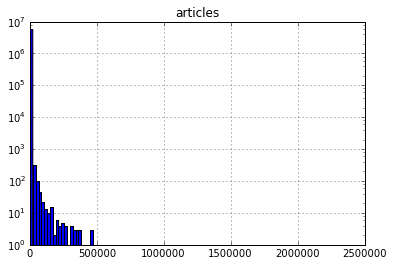

In [40]:
%matplotlib inline
articles_per_user_df.hist(log=True, bins=100)

### Edits per Article

In [41]:
edits_per_article = sqlCtx.sql('select article_id,count(1) as number_of_edits from filtered_edits group by article_id,article_title').collect()

In [42]:
edits_per_article_df = pd.DataFrame(
    edits_per_article, 
    columns = ('article_id', 'edits')
)
edits_per_article_df = edits_per_article_df.set_index('article_id')

In [43]:
np.percentile(edits_per_article_df['edits'], 75)

50.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c8fcf22d0>]], dtype=object)

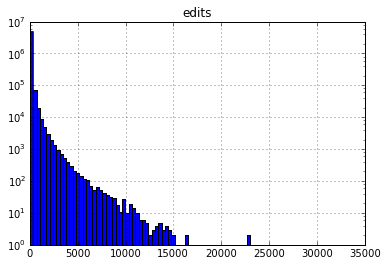

In [44]:
%matplotlib inline
edits_per_article_df.hist(log=True, bins=100)

### Users per Article

In [45]:
editors_per_article = sqlCtx.sql('select article_id, count(distinct(user_id)) as number_of_editors from filtered_edits group by article_id').collect()

In [46]:
editors_per_article_df = pd.DataFrame(
    editors_per_article, 
    columns = ('article_id', 'editors')
)
editors_per_article_df = editors_per_article_df.set_index('article_id')

In [47]:
np.percentile(editors_per_article_df['editors'], 75)

26.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c94698450>]], dtype=object)

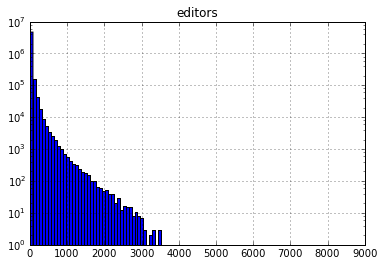

In [48]:
%matplotlib inline
editors_per_article_df.hist(log=True, bins=100)